In [1]:
# Set project root
import os
import sys

# Manually set the path to the project root
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.transform import Rotation as R

# Fix randomness
np.random.seed(0)

In [3]:
class CalibrationSimple:
    """
    Adapted Zhang's camera calibration method for estimating intrinsic parameters
    from homographies between multiple planar templates in a single scene.
    This version assumes zero skew (s = 0), known principal point (cx, cy), and
    square pixels (fx = fy).
    """
    
    def __init__(self):
        self.intrinsic_matrix = None
        self.homographies = []
    
    def _build_v_ij(self, H: np.ndarray, i: int, j: int) -> np.ndarray:
        """
        Compute the vector v_ij used in the Zhang-style calibration constraint:
        v_ij = [h1i*h1j, h1i*h2j + h2i*h1j, h2i*h2j, h3i*h1j + h1i*h3j, h3i*h2j + h2i*h3j, h3i*h3j]
        
        Args:
            H: homography matrix (3x3)
            i, j: column indices for the constraint
            
        Returns:
            v_ij: constraint vector (6,)
        """
        h = H.T  # transpose to access columns easily
        return np.array([
            h[i, 0] * h[j, 0],
            h[i, 0] * h[j, 1] + h[i, 1] * h[j, 0],
            h[i, 1] * h[j, 1],
            h[i, 0] * h[j, 2] + h[i, 2] * h[j, 0],
            h[i, 1] * h[j, 2] + h[i, 2] * h[j, 1],
            h[i, 2] * h[j, 2]
        ])
    
    def add_homography(self, H: np.ndarray):
        """
        Add a homography to the calibration dataset.
        
        Args:
            H: homography matrix (3x3)
        """
        if H.shape != (3, 3):
            raise ValueError("Homography must be a 3x3 matrix")
        self.homographies.append(H.copy())
    
    def add_homographies(self, Hs: list[np.ndarray]):
        """
        Add multiple homographies to the calibration dataset.
        
        Args:
            Hs: list of homography matrices (each 3x3)
        """
        for H in Hs:
            self.add_homography(H)
    
    def calibrate(self, principal_point=None) -> np.ndarray:
        """
        Estimate the intrinsic matrix K from the stored homographies.
        
        Args:
            principal_point: tuple (cx, cy) if known, otherwise assumes image center
            
        Returns:
            K: intrinsic matrix (3x3)
            
        Raises:
            ValueError: if fewer than 1 homography is available (since we have more constraints)
        """
        if len(self.homographies) < 1:  # Need fewer homographies now
            raise ValueError("At least 1 homography is required for calibration with known constraints")
        
        # Set principal point (default to image center if not provided)
        if principal_point is None:
            raise ValueError("Principal point (cx, cy) must be provided")
        else:
            cx, cy = principal_point
        
        V = []

        # Constraint 1: Zero skew (B12 = 0)
        V.append([0, 1, 0, 0, 0, 0])
        
        # Constraint 2: Square pixels (B11 = B22, so B11 - B22 = 0)
        V.append([1, 0, -1, 0, 0, 0])
        
        # Constraint 3: Known cx (B13 = -cx * B11)
        # This gives us: B13 + cx * B11 = 0
        V.append([cx, 0, 0, 1, 0, 0])
        
        # Constraint 4: Known cy (B23 = -cy * B22 = -cy * B11 since B11 = B22)
        # This gives us: B23 + cy * B11 = 0  
        V.append([cy, 0, 0, 0, 1, 0])

        # Add constraints from homographies (you might need fewer now)
        for H in self.homographies:
            H_norm = H / H[2, 2]  # Normalize
            v12 = self._build_v_ij(H_norm, 0, 1)  # v_12
            v11 = self._build_v_ij(H_norm, 0, 0)  # v_11  
            v22 = self._build_v_ij(H_norm, 1, 1)  # v_22
            
            V.append(v12)
            V.append(v11 - v22)
            
        V = np.vstack(V)
        
        # Solve Vb = 0 using SVD
        _, _, Vh = np.linalg.svd(V)
        b = Vh[-1, :]  # last row corresponds to smallest singular value

        # b = [B11, B12, B22, B13, B23, B33]
        B11, B12, B22, B13, B23, B33 = b
        
        # Simplified parameter extraction
        # Since B11 = B22, B12 = 0, B13 = -cx*B11, B23 = -cy*B11
        
        # The focal length f (since fx = fy = f)
        scale = B33 + cx * B13 + cy * B23  # This should equal B33 - cx²*B11 - cy²*B11
        f = np.sqrt(scale / B11)
        
        # Construct the intrinsic matrix
        K = np.array([
            [f,  0, cx],
            [0,  f, cy], 
            [0,  0,  1]
        ])
        
        self.intrinsic_matrix = K
        return K
    
    def get_intrinsic_matrix(self) -> np.ndarray:
        """
        Get the estimated intrinsic matrix.
        
        Returns:
            K: intrinsic matrix (3x3) or None if calibration hasn't been performed
        """
        return self.intrinsic_matrix
    
    def reset(self):
        """
        Clear all stored homographies and reset the calibration state.
        """
        self.homographies.clear()
        self.intrinsic_matrix = None
    
    def get_num_homographies(self) -> int:
        """
        Get the number of stored homographies.
        
        Returns:
            Number of homographies
        """
        return len(self.homographies)

In [4]:
def generate_pose():
    """Generate a random valid camera pose for a frontal planar target."""
    # Random distance between 0.5m and 3.0m
    distance = np.random.uniform(0.5, 3.0)
    
    # Random tilt angles (max 30 degrees)
    tilt_x = np.random.uniform(-30, 30) * np.pi / 180
    tilt_y = np.random.uniform(-30, 30) * np.pi / 180
    
    # Random in-plane rotation (max 90 degrees)
    rot_z = np.random.uniform(-90, 90) * np.pi / 180
    
    # Create rotation matrix from Euler angles (ZYX order)
    rotation = R.from_euler('zyx', [rot_z, tilt_y, tilt_x])
    R_gt = rotation.as_matrix()
    
    # Translation: primarily along Z-axis with small XY offset
    offset_x = np.random.uniform(-0.3, 0.3) * distance
    offset_y = np.random.uniform(-0.3, 0.3) * distance
    t_gt = np.array([offset_x, offset_y, distance])
    
    return R_gt, t_gt

In [5]:
def add_homography_noise(H, sigma):
    # Add noise to all elements
    noise = np.random.normal(0, sigma, (3, 3))
    H_noisy_unnormalized = H + noise
    
    # Normalize (as would happen in practice)
    H_noisy = H_noisy_unnormalized / H_noisy_unnormalized[2, 2]
    
    return H_noisy

In [6]:
def compute_viewing_angle(R):
    """Compute the viewing angle (tilt from frontal view) in degrees."""
    # The viewing angle is the angle between the camera's Z-axis and target normal
    # Target normal in camera coordinates is the third column of R^T
    camera_z = np.array([0, 0, 1])
    target_normal = R.T @ np.array([0, 0, 1])  # Normal to the plane in camera coords
    
    # Compute angle between vectors
    cos_angle = np.dot(camera_z, target_normal)
    angle = np.arccos(np.clip(cos_angle, -1, 1)) * 180 / np.pi
    
    return angle

In [7]:
def generate_test_homographies(K, n, sigma):
    """
    Generate synthetic homographies for camera calibration testing.

    Args:
        K: Camera intrinsic matrix.
        n: Number of homographies to generate.
        sigma: Standard deviation of the noise.

    Returns:
        - the list of noisy synthetic homographies
        - the list of ground truth poses (R_gt, t_gt)
        - the list of noisy poses (R_noisy, t_noisy)
        - the list of distances
        - the list of angles
    """
    homographies = []
    poses_gt = []
    distances = []
    angles = []

    for _ in range(n):
        # Generate random valid pose
        R_gt, t_gt = generate_pose()

        # Compute the homography
        H_gt = K @ np.hstack((R_gt[:, :2], t_gt.reshape(3, 1)))

        # Add noise to the homography
        H_noisy = add_homography_noise(H_gt, sigma)

        # Store the results and compute stats
        homographies.append(H_noisy)
        poses_gt.append((R_gt, t_gt))

        distances.append(np.linalg.norm(t_gt))
        angles.append(compute_viewing_angle(R_gt))

    return homographies, poses_gt, distances, angles

In [8]:
def analyze_calibration_noise(K_gt, n_homographies, n_trials=50):
    """
    Analyze the effect of noise on camera calibration accuracy.
    
    Args:
        K_gt: Ground truth camera intrinsic matrix
        n_homographies: Number of homographies to generate for each trial
        n_trials: Number of trials to run for each noise level
    
    Returns:
        noise_levels: Array of noise levels tested
        mean_focal_lengths: Mean focal length estimates for each noise level
        std_focal_lengths: Standard deviation of focal length estimates
    """
    # Define noise levels from 0 to 0.2
    noise_levels = np.arange(0, 0.21, 0.01)
    
    # Storage for results
    mean_focal_lengths = []
    std_focal_lengths = []
    
    # Ground truth focal length (assuming fx = fy)
    # f_gt = K_gt[0, 0]
    principal_point = (K_gt[0, 2], K_gt[1, 2])
    
    # print(f"Ground truth focal length: {f_gt}")
    # print(f"Running {n_trials} trials for each of {len(noise_levels)} noise levels...")
    
    for i, sigma in enumerate(noise_levels):
        # print(f"Testing noise level {sigma:.3f} ({i+1}/{len(noise_levels)})")
        
        focal_estimates = []
        
        for trial in range(n_trials):
            try:
                # Generate noisy homographies
                homographies, poses_gt, distances, angles = generate_test_homographies(K_gt, n_homographies, sigma)

                # Create calibration object and calibrate
                calibration = CalibrationSimple()
                calibration.add_homographies(homographies)
                K_estimated = calibration.calibrate(principal_point)
                
                # Extract focal length (assuming fx = fy)
                f_estimated = K_estimated[0, 0]
                focal_estimates.append(f_estimated)
                
            except Exception as e:
                print(f"  Trial {trial} failed with sigma={sigma:.3f}: {e}")
                continue
        
        if focal_estimates:
            mean_f = np.mean(focal_estimates)
            std_f = np.std(focal_estimates)
            
            mean_focal_lengths.append(mean_f)
            std_focal_lengths.append(std_f)
            
            print(f"  Mean focal length: {mean_f:.2f} ± {std_f:.2f}")
        else:
            print(f"  All trials failed for sigma={sigma:.3f}")
            mean_focal_lengths.append(np.nan)
            std_focal_lengths.append(np.nan)
    
    return noise_levels, np.array(mean_focal_lengths), np.array(std_focal_lengths)

def plot_calibration_results(noise_levels, mean_focal_lengths, std_focal_lengths, K_gt):
    """
    Plot the calibration results showing focal length vs noise level.
    """
    f_gt = K_gt[0, 0]
    
    plt.figure(figsize=(12, 8))
    
    # Plot 1: Mean focal length with error bars
    plt.subplot(2, 1, 1)
    plt.errorbar(noise_levels, mean_focal_lengths, yerr=std_focal_lengths, 
                 marker='o', capsize=5, capthick=2, linewidth=2, markersize=4)
    plt.axhline(y=f_gt, color='r', linestyle='--', linewidth=2, label=f'Ground Truth (f={f_gt})')
    plt.xlabel('Noise Level (σ)')
    plt.ylabel('Estimated Focal Length')
    plt.title('Camera Calibration Accuracy vs Noise Level')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Plot 2: Relative error
    plt.subplot(2, 1, 2)
    relative_error = np.abs(mean_focal_lengths - f_gt) / f_gt * 100
    plt.plot(noise_levels, relative_error, 'o-', linewidth=2, markersize=4, color='red')
    plt.xlabel('Noise Level (σ)')
    plt.ylabel('Absolute Relative Error (%)')
    plt.title('Focal Length Estimation Error vs Noise Level')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    # print("\nSummary:")
    # print("="*50)
    # for i, sigma in enumerate(noise_levels[::5]):  # Print every 5th value
    #     if not np.isnan(mean_focal_lengths[i*5]):
    #         rel_err = abs(mean_focal_lengths[i*5] - f_gt) / f_gt * 100
    #         print(f"σ={sigma:.2f}: f={mean_focal_lengths[i*5]:.1f}±{std_focal_lengths[i*5]:.1f}, "
    #               f"error={rel_err:.2f}%")

def run_calibration_noise_analysis(K_gt, n_homographies=100, n_trials=50):
    """
    Complete pipeline to analyze calibration noise sensitivity.
    """
    # print("Starting calibration noise analysis...")
    # print(f"Parameters: {n_homographies} homographies, {n_trials} trials per noise level")
    # print("-" * 60)
    
    # Run the analysis
    noise_levels, mean_focal_lengths, std_focal_lengths = analyze_calibration_noise(
        K_gt, n_homographies, n_trials
    )
    
    # Plot results
    plot_calibration_results(noise_levels, mean_focal_lengths, std_focal_lengths, K_gt)
    
    return noise_levels, mean_focal_lengths, std_focal_lengths

In [9]:
# Define ground truth K
K_gt = np.array([
    [1000, 0, 480],
    [0, 1000, 640],
    [0, 0, 1]
])

# Define the number of homographies
n = 100

  Mean focal length: 1000.00 ± 0.00
  Mean focal length: 1001.14 ± 13.45
  Mean focal length: 1013.94 ± 30.51
  Mean focal length: 1027.92 ± 47.69
  Mean focal length: 1055.68 ± 53.76
  Mean focal length: 1088.00 ± 90.05
  Mean focal length: 1106.80 ± 113.70
  Mean focal length: 1154.93 ± 103.80
  Mean focal length: 1204.62 ± 143.39
  Mean focal length: 1225.24 ± 163.81
  Mean focal length: 1259.96 ± 195.81
  Mean focal length: 1292.07 ± 184.22
  Mean focal length: 1434.41 ± 687.56
  Mean focal length: 1606.77 ± 508.37
  Mean focal length: 1538.20 ± 455.19
  Mean focal length: 1521.65 ± 473.99


/tmp/ipykernel_26182/3470870105.py:118: RuntimeWarning: invalid value encountered in sqrt
  f = np.sqrt(scale / B11)


  Mean focal length: nan ± nan
  Mean focal length: nan ± nan
  Mean focal length: nan ± nan
  Mean focal length: 1990.41 ± 1605.95
  Mean focal length: nan ± nan


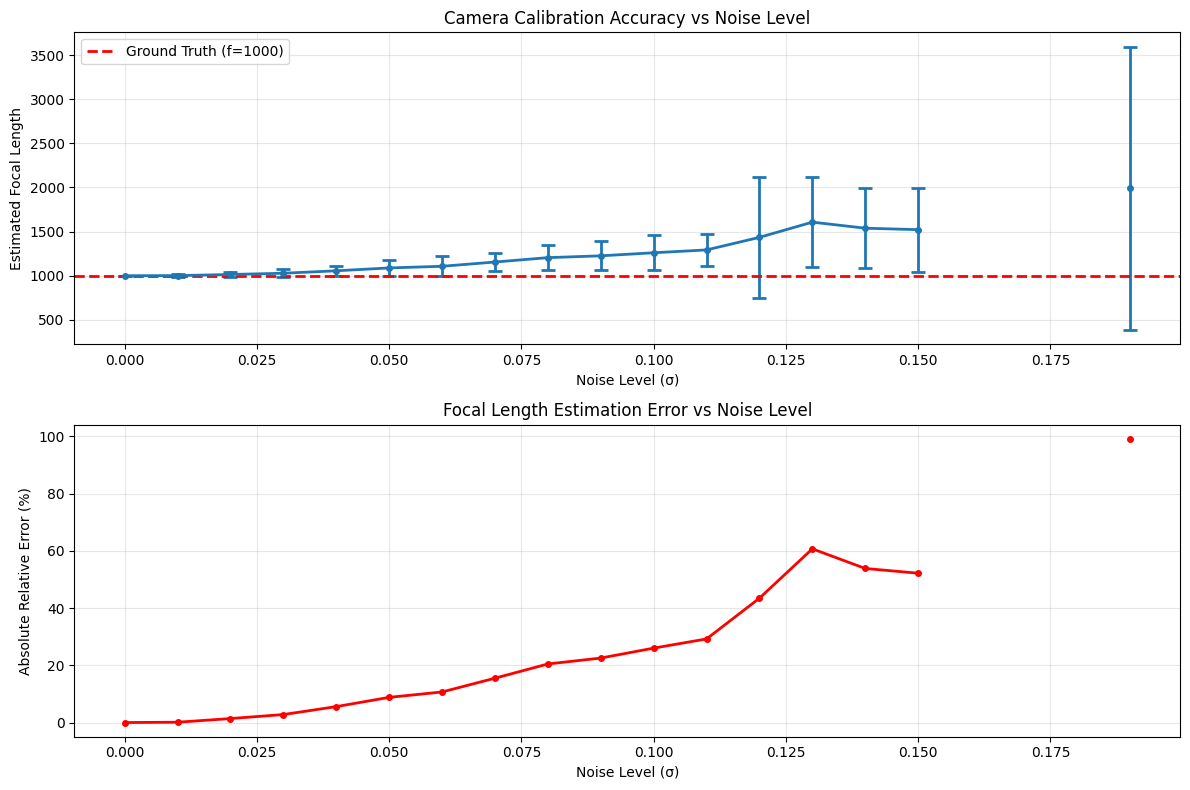

In [10]:
# Run the analysis
noise_levels, mean_f, std_f = run_calibration_noise_analysis(K_gt, n_homographies=n, n_trials=50)